
# Stationarity Analysis – Smart Meter Time Series (Self‑Contained)

This notebook reloads the **London smart meters** preprocessed dataset, extracts one half-hourly series, and performs **stationarity analysis**:
- Visual inspection (rolling mean & std)
- Statistical tests: **ADF** and **KPSS**
- Common transforms (log, differencing, seasonal differencing), with a comparison table

In [1]:
%cd ..

/home/nevin/projects/HSLU.Time/lecture_exercises


In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller, kpss

from src.utils.data_utils import compact_to_expanded

/home/nevin/projects/HSLU.Time/lecture_exercises/src/utils/data_utils.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
preprocessed_dir = Path("./data/london_smart_meters/preprocessed")
merged_parquet = preprocessed_dir / "london_smart_meters_merged_block_0-7.parquet"

assert preprocessed_dir.is_dir(), "Run the preprocessing notebook to create the preprocessed directory first."
assert merged_parquet.exists(), f"Missing: {merged_parquet}"

block = "block_7"
lclid = "MAC000193"
analysis_period = slice("2012-10-01", "2012-10-31")
period = 48


In [ ]:
block_df = pd.read_parquet(merged_parquet)
exp_block_df = compact_to_expanded(
    block_df[block_df.file == block],
    timeseries_col="energy_consumption",
    static_cols=["frequency", "series_length", "stdorToU", "Acorn", "Acorn_grouped", "file"],
    time_varying_cols=['holidays','visibility','windBearing','temperature','dewPoint','pressure',
                       'apparentTemperature','windSpeed','precipType','icon','humidity','summary'],
    ts_identifier="LCLid"
)
print("Expanded rows:", len(exp_block_df))


  0%|          | 0/50 [00:00<?, ?it/s]

Expanded rows: 1611792


In [5]:
ts_df = exp_block_df[exp_block_df.LCLid == lclid].set_index("timestamp")
ts_clean = ts_df.loc[analysis_period, "energy_consumption"].dropna()

print(f"Analyzing period: {analysis_period.start} to {analysis_period.stop}")
print(f"Data points: {len(ts_clean):,}")
print(f"Missing values: {ts_df.loc[analysis_period, 'energy_consumption'].isnull().sum()}")
print("\nBasic Statistics:")
print(f"Mean: {ts_clean.mean():.3f} kWh")
print(f"Std:  {ts_clean.std():.3f} kWh")
print(f"Min:  {ts_clean.min():.3f} kWh")
print(f"Max:  {ts_clean.max():.3f} kWh")

Analyzing period: 2012-10-01 to 2012-10-31
Data points: 1,440
Missing values: 48

Basic Statistics:
Mean: 0.284 kWh
Std:  0.370 kWh
Min:  0.003 kWh
Max:  2.696 kWh


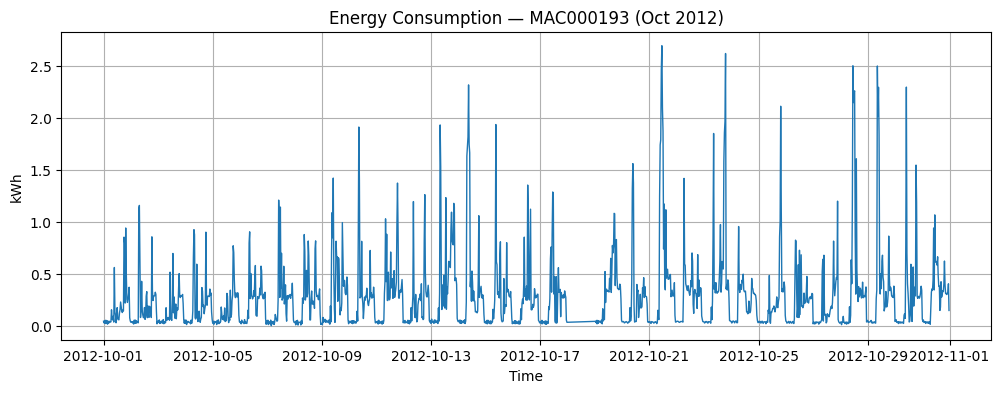

In [6]:
plt.figure(figsize=(12,4))
plt.plot(ts_clean, linewidth=1)
plt.title(f"Energy Consumption — {lclid} (Oct 2012)")
plt.xlabel("Time"); plt.ylabel("kWh")
plt.grid(True); plt.show()

In [8]:
def adf_test(x: pd.Series):
    x = x.dropna()
    stat, p, lags, nobs, crit, icbest = adfuller(x, autolag="AIC")
    return {
        "test": "ADF",
        "statistic": stat,
        "p_value": p,
        "lags_used": lags,
        "n_obs": nobs,
        "critical_values": crit,
        "ic_best": icbest,
        "decision": "Reject H0 (likely stationary)" if p < 0.05 else "Fail to reject H0 (likely non-stationary)",
    }

In [9]:
def kpss_test(x: pd.Series, regression: str = "c"):
    x = x.dropna()
    stat, p, lags, crit = kpss(x, regression=regression, nlags="auto")
    return {
        "test": f"KPSS ({'level' if regression=='c' else 'trend'})",
        "statistic": stat,
        "p_value": p,
        "lags_used": lags,
        "critical_values": crit,
        "decision": "Reject H0 (likely non-stationary)" if p < 0.05 else "Fail to reject H0 (likely stationary)",
    }

In [10]:
def stationarity_visual(x: pd.Series, window: int = 48, title: str = "Visual Stationarity Check"):
    x = x.dropna()
    rm = x.rolling(window).mean()
    rs = x.rolling(window).std()
    plt.figure(figsize=(12,4))
    plt.plot(x, label="Series", linewidth=1)
    plt.plot(rm, label=f"Rolling mean ({window})", linewidth=2)
    plt.plot(rs, label=f"Rolling std ({window})", linewidth=2)
    plt.title(title)
    plt.xlabel("Time"); plt.ylabel("kWh")
    plt.grid(True); plt.legend()
    plt.show()

In [11]:
def try_transforms(x: pd.Series, seasonal_period: int = 48):
    out = {
        "original": x,
        "log1p": np.log1p(x).replace([np.inf, -np.inf], np.nan),
        "diff_1": x.diff(),
        "seasonal_diff": x.diff(seasonal_period),
        "log1p_diff_1": np.log1p(x).diff(),
        "log1p_seasonal_diff": np.log1p(x).diff(seasonal_period),
        "diff_1_then_seasonal": x.diff().diff(seasonal_period),
    }
    return {k: v.dropna() for k, v in out.items()}

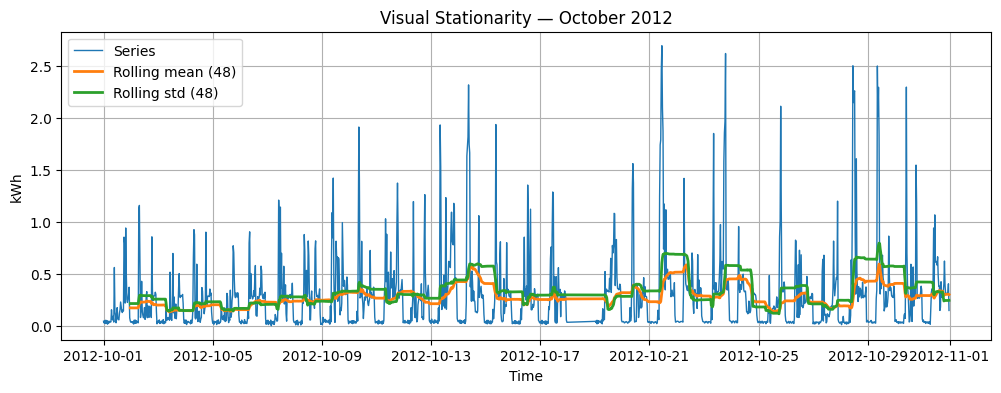

In [12]:
stationarity_visual(ts_clean, window=period, title="Visual Stationarity — October 2012")

In [13]:
adf_res = adf_test(ts_clean)
kpss_level_res = kpss_test(ts_clean, regression="c")   # level
kpss_trend_res = kpss_test(ts_clean, regression="ct")  # trend

print("ADF:", adf_res)
print("KPSS (level):", kpss_level_res)
print("KPSS (trend):", kpss_trend_res)


ADF: {'test': 'ADF', 'statistic': -15.990764991748183, 'p_value': 6.675231016874415e-29, 'lags_used': 0, 'n_obs': 1439, 'critical_values': {'1%': -3.4349024693573584, '5%': -2.8635506057382325, '10%': -2.5678404322793846}, 'ic_best': 281.14177795616115, 'decision': 'Reject H0 (likely stationary)'}
KPSS (level): {'test': 'KPSS (level)', 'statistic': 0.4985040850779042, 'p_value': 0.04200358444191347, 'lags_used': 19, 'critical_values': {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}, 'decision': 'Reject H0 (likely non-stationary)'}
KPSS (trend): {'test': 'KPSS (trend)', 'statistic': 0.0746720263528633, 'p_value': 0.1, 'lags_used': 19, 'critical_values': {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}, 'decision': 'Fail to reject H0 (likely stationary)'}


/tmp/ipykernel_22163/4210674298.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, p, lags, crit = kpss(x, regression=regression, nlags="auto")


In [14]:
rows = []
for name, series in try_transforms(ts_clean, seasonal_period=period).items():
    try:
        a = adf_test(series)
    except Exception as e:
        a = {"p_value": np.nan, "decision": f"error: {e}"}
    try:
        k = kpss_test(series, regression="c")
    except Exception as e:
        k = {"p_value": np.nan, "decision": f"error: {e}"}
    rows.append({
        "transform": name,
        "adf_p": a.get("p_value", np.nan),
        "adf_decision": a.get("decision", "n/a"),
        "kpss_p": k.get("p_value", np.nan),
        "kpss_decision": k.get("decision", "n/a"),
    })

summary = pd.DataFrame(rows).set_index("transform").sort_index()
summary

/tmp/ipykernel_22163/4210674298.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, p, lags, crit = kpss(x, regression=regression, nlags="auto")
/tmp/ipykernel_22163/4210674298.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, p, lags, crit = kpss(x, regression=regression, nlags="auto")
/tmp/ipykernel_22163/4210674298.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, p, lags, crit = kpss(x, regression=regression, nlags="auto")
/tmp/ipykernel_22163/4210674298.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater t

,adf_p,adf_decision,kpss_p,kpss_decision
transform,,,,
diff_1,1.879793e-22,Reject H0 (likely stationary),0.100000,Fail to reject H0 (likely stationary)
diff_1_then_seasonal,5.383451e-23,Reject H0 (likely stationary),0.100000,Fail to reject H0 (likely stationary)
log1p,4.652223e-28,Reject H0 (likely stationary),0.051684,Fail to reject H0 (likely stationary)
log1p_diff_1,1.046763e-25,Reject H0 (likely stationary),0.100000,Fail to reject H0 (likely stationary)
log1p_seasonal_diff,0.000000e+00,Reject H0 (likely stationary),0.100000,Fail to reject H0 (likely stationary)
original,6.675231e-29,Reject H0 (likely stationary),0.042004,Reject H0 (likely non-stationary)
seasonal_diff,2.249485e-30,Reject H0 (likely stationary),0.100000,Fail to reject H0 (likely stationary)


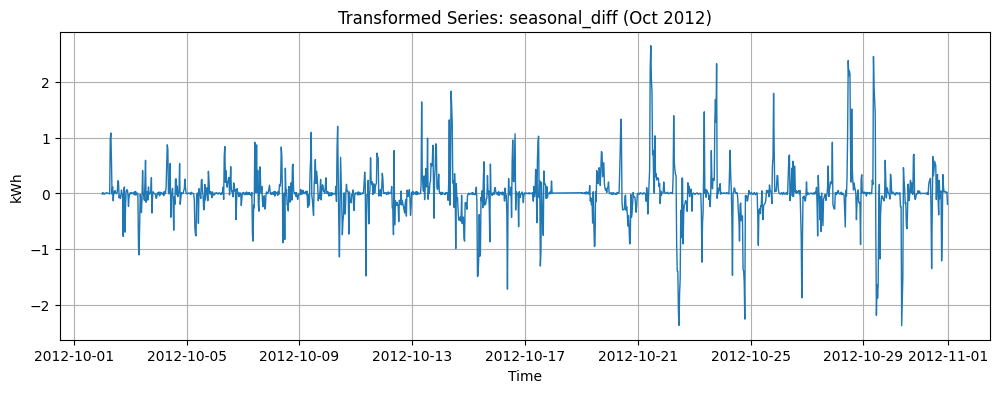

In [15]:
best = "seasonal_diff"  # adjust after you review 'summary' above
ts_best = try_transforms(ts_clean, seasonal_period=period)[best]

plt.figure(figsize=(12,4))
plt.plot(ts_best, linewidth=1)
plt.title(f"Transformed Series: {best} (Oct 2012)")
plt.xlabel("Time"); plt.ylabel("kWh")
plt.grid(True); plt.show()


### Stationarity Analysis

**Visual inspection:**
The October 2012 half-hourly energy consumption series displays clear daily and weekly seasonal variation.
The rolling mean (window = 48) varies over the month, which implies that the mean level varies, and the rolling standard deviation also varies slightly.
This suggests that the original series is non-stationary, primarily because of the repeating daily and weekly cycles.

**Statistical tests:**
The ADF test strongly rejects the null of non-stationarity (p ≪ 0.05), suggesting a stationary process,
whereas the KPSS (level) test rejects the null of stationarity (p < 0.05), implying non-stationarity.
The KPSS (trend) test, however, fails to reject its null, implying trend-stationarity of the data.
This ambiguous outcome is typical behavior for seasonal time series with strong trend and periodic components.

After seasonal differencing (lag = 48), the two tests concur:
ADF rejects non-stationarity 
KPSS fails to reject stationarity, which affirms the fact that the differenced series is stationary.
Therefore, the time series is not stationary in its raw state but becomes stationary after seasonal differencing.